[Supervised Learning] Predictive Analysis (Regression)
-----
Diogo Pessoa

Explore a predictive analysis using regression models to improve user experience. Refining the re-stock strategy by considering the bike type per route, to predict the number of bikes needed at each station at different times of the day.

* Apply regression model for Multi Classification problem.
* Predict which Station will need more Bike by Type (Eletric vs Classic) at different times of Workdays day.

In [1]:
"""Uncomment this Section if running locally or working on this notebook and loading dataset directly here."""
# import os
# import sys
#
# from dotenv import load_dotenv
#
# # Load environment variables from a .env file
# load_dotenv()
# images_path = os.getenv('IMAGES_PATH')
# data_dir = os.getenv('DATA_COLLECTION_DIR')
#
# # Loading local helper modules
# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path)
# # data_collection
# %run './data_collection.ipynb'
# # features engineering
# %run './feature_engineering.ipynb'
# """
# Local Dataset from local files (download if not present)
#  :returns sampled_df_with_added_features: DataFrame, sampled_df_with_added_features_indexed: DataFrame
# """

'Uncomment this Section if running locally or working on this notebook and loading dataset directly here.'

In [9]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Filtering by workdays to reduce the data size and improve the model's performance
df_workdays = sampled_df_with_added_features_indexed.filter(sampled_df_with_added_features_indexed['week_day'] == 'Workday')
features = ['day_period_index', 'start_station_id_index', 'end_station_id_index']

# Create a VectorAssembler to combine the features into a single vector column
assembler = VectorAssembler(inputCols=features, outputCol="features")

# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Initialize the LogisticRegression
log_reg = LogisticRegression(labelCol="rideable_type_index", featuresCol="scaled_features", maxIter=10, family="multinomial")

# Define the pipeline
pipeline = Pipeline(stages=[assembler, scaler, log_reg])

# Split the data into training and testing sets
(train_data, test_data) = df_workdays.randomSplit([0.8, 0.2])

# Train the model
model = pipeline.fit(train_data)

# Make predictions based on test data split
predictions = model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="rideable_type_index", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Model accuracy: {accuracy:.2f}")


24/02/06 20:36:50 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Model accuracy: 0.64


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Precision and Recall
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
print(f"Model accuracy: {precision:.2f}")
print(f"Model accuracy: {recall:.2f}")
# Creating lists for plotting
metrics = ['Precision', 'Recall']
values = [precision, recall]

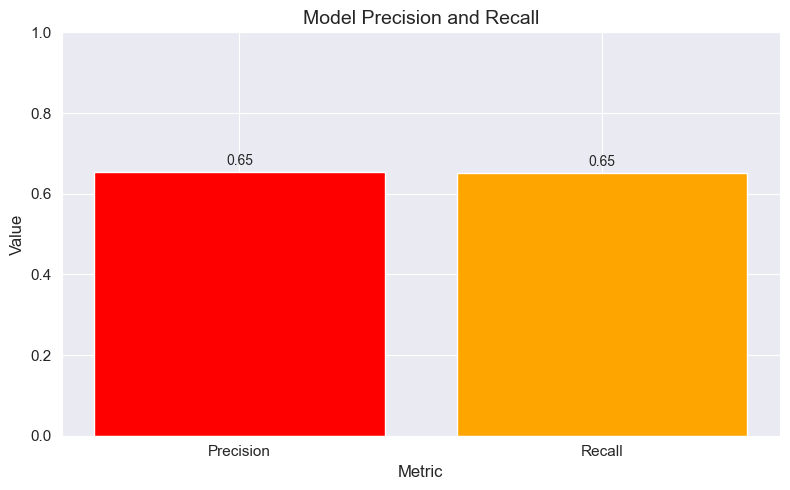

In [27]:
plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, values, color=['red', 'orange'], edgecolor='white')

# Adding value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# Adding title and labels
plt.title('Workday Model Precision and Recall', fontsize=14)
plt.xlabel('Metric', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.ylim(0, 1)  # Assuming precision and recall values are between 0 and 1
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Show plot
plt.tight_layout()
# Save fig
plt.savefig(os.path.join(images_path, 'log_regression_precision_recall.png'))
plt.show()

In [11]:
from pyspark.sql.functions import col
# Generate confusion matrix
confusion_matrix = predictions.groupBy('rideable_type_index').pivot('prediction', [0, 1]).count().na.fill(0).orderBy('rideable_type_index')

+-------------------+----+---+
|rideable_type_index|   0|  1|
+-------------------+----+---+
|                0.0|2999| 94|
|                1.0|1699|126|
+-------------------+----+---+



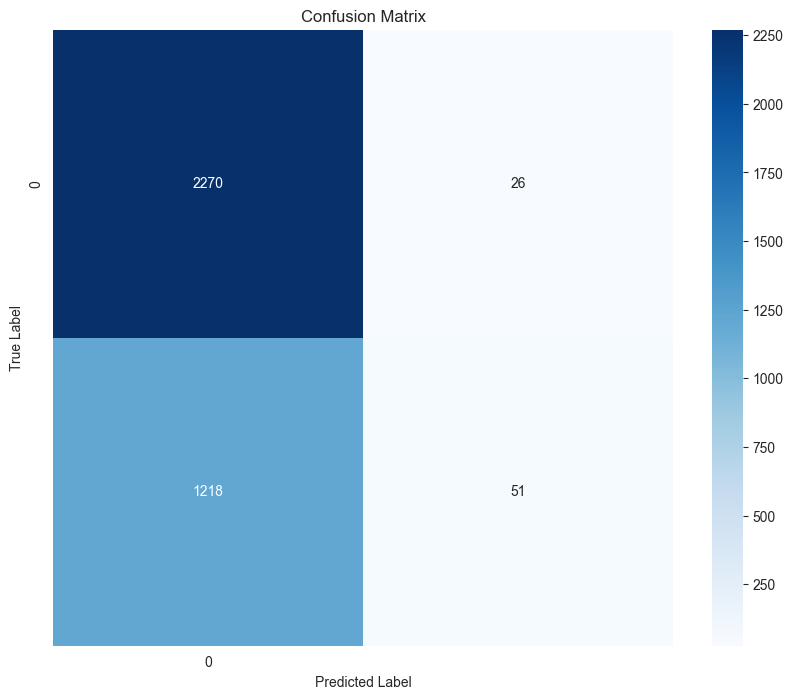

In [26]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Collect the confusion matrix data
cm_data = confusion_matrix.toPandas()
cm_data = cm_data.set_index('rideable_type_index')

# Convert to numpy for plotting
cm_array = np.array(cm_data)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_array, annot=True, fmt='d', cmap='Blues', xticklabels=range(1), yticklabels=range(1))
plt.title('Confusion Matrix - Workday')
plt.xlabel('Bike Type Eletric/Classic')
plt.ylabel('True Label')
plt.savefig(os.path.join(images_path,'log_reg_confusion_matrix.png'))
plt.show()


In [18]:
# Filtering by workdays to reduce the data size and improve the model's performance
df_non_workdays = sampled_df_with_added_features_indexed.filter(sampled_df_with_added_features_indexed['week_day'] == 'non-Workday')
features = ['day_period_index', 'start_station_id_index', 'end_station_id_index']

# Create a VectorAssembler to combine the features into a single vector column
assembler = VectorAssembler(inputCols=features, outputCol="features")

# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Initialize the LogisticRegression
log_reg = LogisticRegression(labelCol="rideable_type_index", featuresCol="scaled_features", maxIter=10, family="multinomial")

# Define the pipeline
pipeline = Pipeline(stages=[assembler, scaler, log_reg])

# Split the data into training and testing sets
(train_data, test_data) = df_non_workdays.randomSplit([0.8, 0.2])

# Train the model
model = pipeline.fit(train_data)

# Make predictions based on test data split
predictions = model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="rideable_type_index", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Model accuracy: {accuracy:.2f}")

Model accuracy: 0.65


In [19]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Precision and Recall
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
print(f"Model accuracy: {precision:.2f}")
print(f"Model accuracy: {recall:.2f}")
# Creating lists for plotting
metrics = ['Precision', 'Recall']
values = [precision, recall]

Model accuracy: 0.65
Model accuracy: 0.65


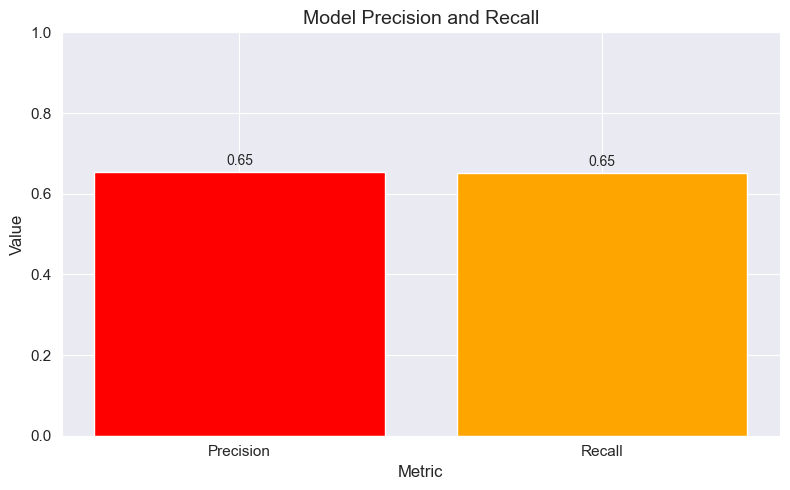

In [25]:
plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, values, color=['red', 'orange'], edgecolor='white')

# Adding value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# Adding title and labels
plt.title('Model Precision and Recall', fontsize=14)
plt.xlabel('Metric', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.ylim(0, 1)  # Assuming precision and recall values are between 0 and 1
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Show plot
plt.tight_layout()
# Save fig
plt.savefig(os.path.join(images_path, 'log_regression_non_workday_precision_recall.png'))
plt.show()

In [21]:
from pyspark.sql.functions import col
# Generate confusion matrix
confusion_matrix = predictions.groupBy('rideable_type_index').pivot('prediction', [0, 1]).count().na.fill(0).orderBy('rideable_type_index')

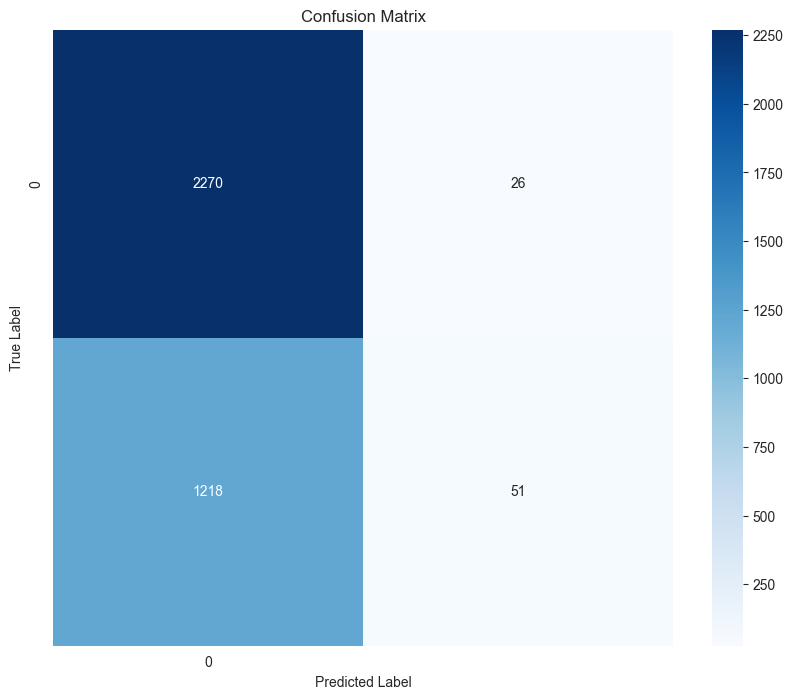

In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Collect the confusion matrix data
cm_data = confusion_matrix.toPandas()
cm_data = cm_data.set_index('rideable_type_index')

# Convert to numpy for plotting
cm_array = np.array(cm_data)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_array, annot=True, fmt='d', cmap='Blues', xticklabels=range(1), yticklabels=range(1))
plt.title('Confusion Matrix - non-Workday')
plt.xlabel('Bike Type Eletric/Classic')
plt.ylabel('True Label')
plt.savefig(os.path.join(images_path,'log_reg_non_workday_confusion_matrix.png'))
plt.show()
